In [1]:
# default_exp sine_model

In [2]:
#hide 
%load_ext autoreload
%autoreload 2

In [3]:
#export
from rtma.imports import *
from rtma.core import *
from rtma.signal import *
from rtma.fft import *
from rtma.stft import *

# Sine Model

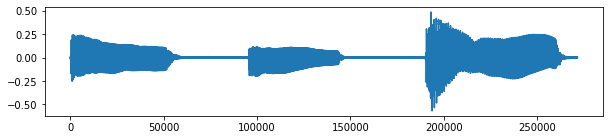

In [4]:
fn = "data/E_octaves_both.wav"
x, sr = load_audio(fn)
plot(x)

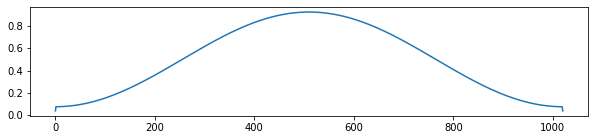

In [5]:
n_fft = 1024
h = 510
m = h*2 + 1
w = get_cola_window('hamming', m, h)
plot(w)

In [6]:
spectrum = list(stft(x, n_fft, h, w))

In [7]:
mx, px = (np.stack(s) for s in zip(*spectrum))

In [8]:
mx.shape, px.shape

((534, 513), (534, 513))

In [9]:
mx = 20*np.log10(mx)

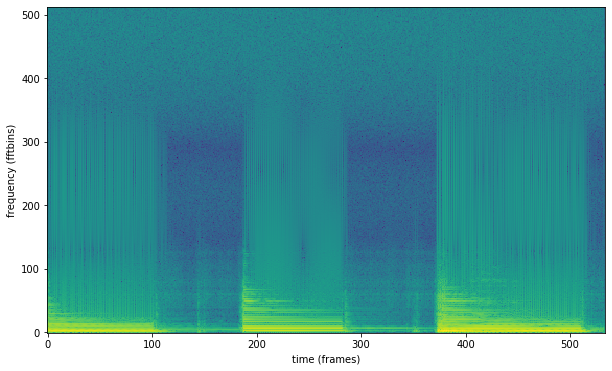

In [10]:
plot_mags(mx)

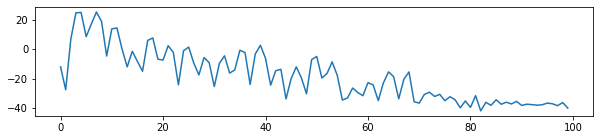

In [11]:
plot(mx[200, :100])

## Peak Detection

In [12]:
#export
def detect_peaks(x, thresh):
    # first and last cannot be peaks
    above_thresh = np.greater(x[1:-1], thresh)
    gt_before = np.greater(x[1:-1], x[:-2])
    gt_after =  np.greater(x[1:-1], x[2:])
    is_peak = above_thresh & gt_before & gt_after
    peaks_i = is_peak.nonzero()[0] + 1
    return peaks_i 

In [13]:
arr = np.array([2, 10, 3, 8, 2, 3, 1, 9, 0, 2, 1])
assert np.array_equal(detect_peaks(arr, 1), [1,3,5,7,9])
assert np.array_equal(detect_peaks(arr, 2), [1,3,5,7])
assert np.array_equal(detect_peaks(arr, 3), [1,3,7])

In [14]:
#export
def plot_peaks(x, peak_i, t=None):
    plt.figure(figsize=(10, 6))
    plt.plot(x)
    plt.plot(peak_i, x[peak_i], marker='x', color='r', linestyle='', markeredgewidth=1.5)
    if t is not None:
        plt.axhline(t, c='g')

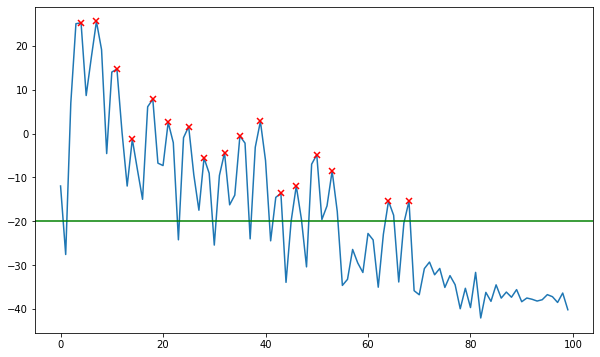

In [15]:
x = mx[200,:100]
t = -20
peak_i = detect_peaks(x, t)
plot_peaks(x, peak_i, t)

## Peak Interpolation

In [16]:
#export
def interpolate_peaks(x, peak_i):
    a, b, c = x[peak_i-1], x[peak_i], x[peak_i+1]
    ipeak_i = peak_i + 0.5 * (a - c) / (a - 2*b + c)
    ipeak_v = b - 0.25 * (a - c) * (ipeak_i - peak_i)
    return ipeak_i, ipeak_v

In [17]:
x = mx[200,:30]
t = -25
peak_i = detect_peaks(x, t)
ipeak_i, ipeak_v = interpolate_peaks(x, peak_i)
peak_i, ipeak_i, ipeak_v

(array([ 4,  7, 11, 14, 18, 21, 25, 28]),
 array([ 3.51175719,  7.061721  , 10.54417648, 14.10603846, 17.60596861,
        21.18053712, 24.68730608, 28.27470026]),
 array([27.25809334, 25.59565951, 16.26360341, -1.2149441 ,  9.09982353,
         2.77221543,  2.24417737, -5.01670619]))

In [18]:
#export
def plot_ipeaks(x, ipeak_i, ipeak_v, peak_i=None, t=None):
    plt.figure(figsize=(10, 6))
    plt.plot(x)
    plt.plot(ipeak_i, ipeak_v, marker='x', color='g', linestyle='', markeredgewidth=1.5)
    if peak_i is not None:
        plt.plot(peak_i, x[peak_i], marker='x', color='r', linestyle='', markeredgewidth=1.5)
    if t is not None:
        plt.axhline(t, c='g')

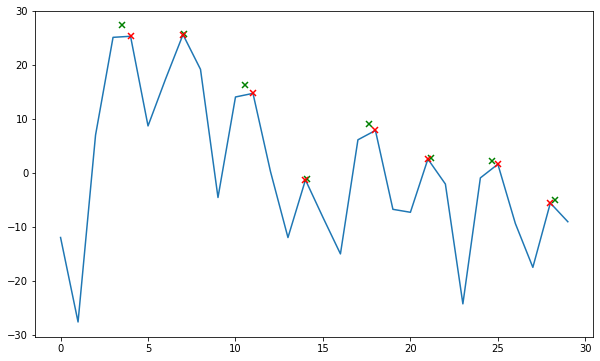

In [19]:
plot_ipeaks(x, ipeak_i, ipeak_v, peak_i=peak_i)

In [20]:
mx.shape

(534, 513)

In [21]:
px[peak_i].shape

(8, 513)

In [22]:
ipeak_freq = sr * ipeak_i / n_fft
ipeak_freq

array([ 164.61361836,  331.0181719 ,  494.25827267,  661.22055259,
        825.27977848,  992.83767748, 1157.21747249, 1325.37657463])

In [23]:
px1 = px[200,:30]
px1

array([0.        , 2.39426695, 2.73322121, 2.92130652, 2.93594136,
       2.98740963, 2.18139388, 2.19852771, 2.22136881, 2.81337294,
       2.82779723, 2.84265389, 2.77504211, 1.5786694 , 1.78125197,
       1.75030312, 3.99467132, 4.19684024, 4.20680314, 4.33234728,
       3.56715528, 3.64729283, 3.65107488, 3.33430127, 3.65765   ,
       3.67386855, 3.66557589, 4.63342634, 4.56832276, 4.63718337])

In [24]:
ipeak_i

array([ 3.51175719,  7.061721  , 10.54417648, 14.10603846, 17.60596861,
       21.18053712, 24.68730608, 28.27470026])

In [25]:
arg2 = np.arange(0, px1.size)
arg2

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29])

In [26]:
ipeak_p = np.interp(ipeak_i, arg2, px1)

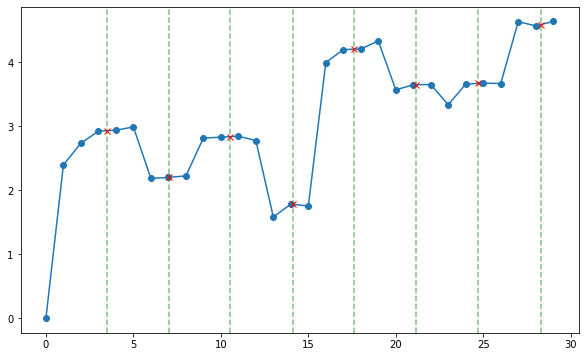

In [27]:
plt.figure(figsize=(10, 6))
plt.plot(arg2, px1, marker='o')
for i in ipeak_i:
    plt.axvline(i, c='g', linestyle='--', alpha=0.5)
plt.plot(ipeak_i, ipeak_p, c='r', linestyle='', marker='x')

## Synthesis

In [28]:
n_fft, sr

(1024, 48000)

In [29]:
def sinc(x, N):
    y = np.sin(N * x/2) / np.sin(x/2)                  # compute the sinc function
    y[np.isnan(y)] = N                                 # avoid NaN if x == 0
    return y

def genBhLobe(x):
    N = 512                                                 # size of fft to use
    f = x*np.pi*2/N                                         # frequency sampling
    df = 2*np.pi/N
    y = np.zeros(x.size)                                    # initialize window
    consts = [0.35875, 0.48829, 0.14128, 0.01168]           # window constants
    for m in range(0,4):                                    # iterate over the four sincs to sum
        y += consts[m]/2 * (sinc(f-df*m, N) + sinc(f+df*m, N))  # sum of scaled sinc functions
    y = y/N/consts[0]                                       # normalize
    return y

In [30]:
def generate_sine_spectrum(ipeak_f, ipeak_v, ipeak_p, N, fs):
    Y = np.zeros(N, dtype=np.complex64)
    hN = N//2
    ipeak_i = ipeak_freq * N / fs
    assert (ipeak_i > 0).all() and (ipeak_i < hN-1).all() # not sure 
    for i, mag, phase in zip(ipeak_i, ipeak_v, ipeak_p):
        bin_remainder = round(i) - i
        lb = np.arange(bin_remainder-4, bin_remainder+5)
        lmag = genBhLobe(lb) * 10**(mag/20)
        bs = np.arange(round(i) - 4, round(i) + 5, dtype=int)        
        for m, b in enumerate(bs):
            if b < 0:      # lobe crosses DC
                Y[-b] += lmag[m]*np.exp(-1j*phase)
            
            elif b > hN:   # lobe crosses nyquist
                Y[b] += lmag[m] * np.exp(-1j*phase)
            
            elif b == 0 or b == hN:   #limits of spectrum
                Y[b] += lmag[m]*np.exp(1j*phase) + lmag[m]*np.exp(-1j*phase)
            
            else:  # pos freq range
                Y[b] += lmag[m]*np.exp(1j*phase)
            
        Y[hN+1:] = Y[hN-1:0:-1].conjugate()
    return Y
            

Y = generate_sine_spectrum(ipeak_freq, ipeak_v, ipeak_p, n_fft, sr)

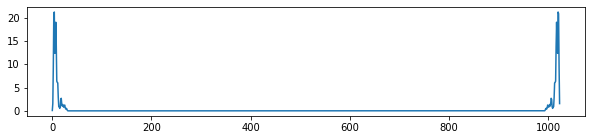

In [31]:
plot(abs(Y))

### blackman window..

In [32]:
bh = genBhLobe(np.arange(20))
bh[:5]

/home/john/miniconda3/envs/rtma/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  


array([ 1.00000000e+00,  6.80543554e-01,  1.96905923e-01,  1.62787456e-02,
       -6.50095043e-21])

In [33]:
bh = get_window('blackmanharris', 512)
bh /= bh.sum()

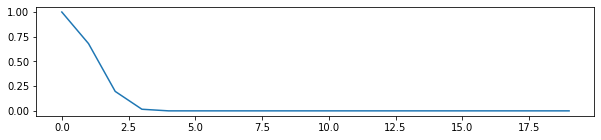

In [34]:
plot(fft_analysis(bh, 512)[0][:20])

In [35]:
fft_analysis(bh, 512)[0][:5]

array([1.00000000e+00, 6.80543554e-01, 1.96905923e-01, 1.62787456e-02,
       4.52955313e-18])

In [36]:
ipeak_freq.shape, ipeak_v.shape

((8,), (8,))

In [70]:
x, sr = load_audio(fn)
n_fft = 512
h = 128
m = h*2 + 1
w = get_cola_window('hamming', n_fft, h)

In [71]:
from scipy.signal import blackmanharris, triang

In [72]:
Ns = 512
H = Ns//4
hNs = Ns//2
yw = np.zeros(Ns)
sw = np.zeros(Ns)
ow = triang(2*H)
print(ow.shape)
sw[hNs-H:hNs+H] = ow
bh = blackmanharris(Ns)
bh = bh / sum(bh)
sw[hNs-H:hNs+H] = sw[hNs-H:hNs+H] / bh[hNs-H:hNs+H]
print(sw.shape)

(256,)
(512,)


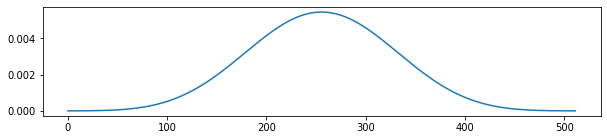

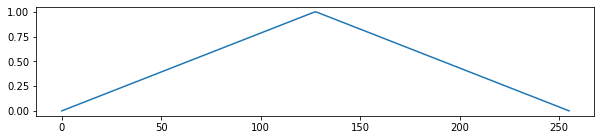

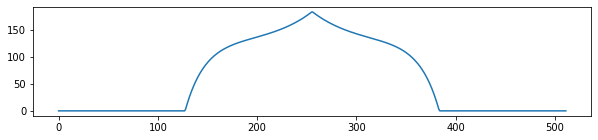

In [73]:
plot(bh)
plot(ow)
plot(sw)

In [74]:
frames = []
for mx, px in stft(x, n_fft, h, w):
    mx_db = 20 * np.log10(mx)
    peak_i = detect_peaks(mx_db, -80)
    ipeak_i, ipeak_m = interpolate_peaks(mx_db, peak_i)
    ipeak_p = np.interp(ipeak_i, np.arange(px.size), px)
    ipeak_f = sr * ipeak_i / Ns
    Y = generate_sine_spectrum(ipeak_f, ipeak_m, ipeak_p, Ns, sr)
#     print(fx.shape, mx.shape, px.shape)
#     Y = generate_sine_spectrum(fx, mx_db, px, Ns, sr)[:Ns//2+1]
    fft_buffer = np.real(np.fft.ifft(Y))
    yw = zero_phase_buffer(fft_buffer, n_window=Ns, reverse=True)
    y = sw*yw
    frames.append(y)

In [75]:
y = synth_frames(frames, H, x.size)
y /= (np.max(abs(y)))
y *= 0.5

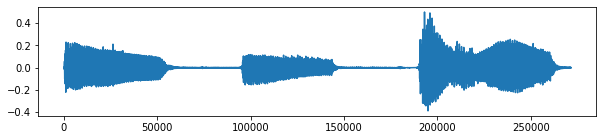

In [76]:
plot(y)

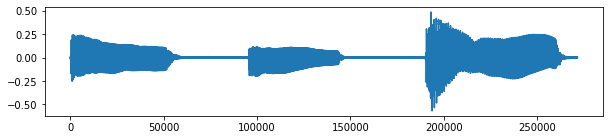

In [77]:
plot(x)

In [78]:
import IPython.display as ipd

In [79]:
ipd.display(ipd.Audio(x, rate=sr))

In [80]:
ipd.display(ipd.Audio(y, rate=sr))